In [1]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_google_vertexai import ChatVertexAI
from langchain_openai import ChatOpenAI
from langsmith import traceable
from langchain.schema import Document
from pydantic import BaseModel, Field
from typing import Optional, Dict, Literal, List, NotRequired, Annotated, TypedDict
from operator import add

import json

from langgraph.constants import Send

from IPython.display import Image, display, Markdown

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_vertexai import VertexAIEmbeddings
embeddings = VertexAIEmbeddings(model="text-embedding-005")

In [3]:
from langchain_chroma import Chroma
persist_directory = 'docs/chroma_from_web/'
vector_store = Chroma(persist_directory = persist_directory,embedding_function = embeddings)

In [ ]:
vector_store.similarity_search_with_relevance_scores("What's innovative entrepreneurship?", k=5)

In [5]:

llm = ChatVertexAI(model="gemini-2.0-flash-exp", temperature=0)
#llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

In [6]:

query_or_respond_system_message = """
Your are an expert on technology innovation management.
You are given a query by the user specified in the user message.
You are to retrieve information related to the query from around 700 articles from the Tim Review Journal.
The retrieval is done using a vector similarity search.
You should decide whether a research is required.
If research is required, handle the query properly.
If more than one topics are involved in the query, no matter how the question is asked, you must divide the query into subtopics. This division rule is very important, take special care of it. 
If there is authors, time, etc. involved, your should specify them in every subquery separately.
If the user does not provide a query related to technology innovation management, you should response with an empty list.
"""

generate_tool_call_system_message = """ 
Generate a tool call based on the query.
Carefully choose the filters agrument to retrieve the information that is most relevant to the query.
The content under the key "author" in metadata contains all the authors of the documents. 
"""

generate_system_message = """ 
Your are an expert on technology innovation management.
You are given a query by the user specified in the user message and some documents retrieved from the Tim Review Journal.
Examine every document carefully and choose choose those you think are relevant to the query. Answer the query based on the chosen documents. 
Generally you should confine your answer to the documents that you have chosen, but you can add information from outside of the documents if the information is considered common sense. 
If the documents do not provide enough information to answer the query, you should clearly state it.
You should use APA 7th edition format in-line citation and generate a reference list at the end of the answer unless the user specifys otherwise.
Generate Markdown formatted answer. 
Use Markdown format for the answer. Use single * for bold and single _ for italics.
When a reference list is generated, make the heading Reference bold.

<query>
{query}
</query>

<documents>
{documents}
</documents>
"""

steer_back_system_prompt = """
Now the user has asked a question that's not related to technology innovation management. Say something to steer the user back on track.
"""


In [7]:

    
class DividedQuery(BaseModel):
    query: str = Field(description="Query for the subtopic.")
    
class DividedQueryList(BaseModel):
    divided_queries: List[DividedQuery] = Field(description="A list of queries for the subtopics.") 
    
class RetrieveState(TypedDict):
    subquery: str
    
class RetrieveInput(BaseModel):
    query: str = Field(description="The query to retrieve the answer for in cosine similarity.")
    #filter: Dict[Literal["author", "title", "year", "month"], str | int] = {}
    filter_author: Optional[str] = Field(default=None, description="Filter property, the authors of the document")
    filter_title: Optional[str] = Field(default=None, description="Filter property, the title of the document")
    filter_year: Optional[int] = Field(default=None, description="Filter property, the year of the document. Should be an integer")
    filter_month: Optional[int] = Field(default=None, description="Filter property, the month of the document. Should be an integer")

class ChosenDocument(BaseModel):
    indeces: List[int] = Field(description="A list of the indeces of the documents that are chosen to be used for the answer. The index start from 0.")
    documents: List[str] = Field(description="A list of the strings of the oringinal text of the documents that are chosen to be used for the answer. The index start from 0.")
    
class TimReviewState(MessagesState):
    query: str
    subqueries: Annotated[list, add]

In [27]:
@traceable
def query_or_respond(state: TimReviewState):
    """Decide whether research is required and rewrite the query if necessary."""
    system_prompt = SystemMessage(content=query_or_respond_system_message)
    human_prompt = HumanMessage(content=state['query'])
    query_llm = llm.with_structured_output(DividedQueryList)
    response = query_llm.invoke([system_prompt, human_prompt])
    return {"subqueries": response.divided_queries}

@traceable
def generate_retrieval_tool_call(state: RetrieveState):
    system_prompt = SystemMessage(content=generate_tool_call_system_message)
    tools = [retrieve]
    retrieve_llm = llm.bind_tools(tools)
    query = state["query"].query
    response = retrieve_llm.invoke([system_prompt] + [HumanMessage(content=query)])

    return {"messages": [response]}

@traceable
def should_research(state: TimReviewState):

    if len(state["subqueries"]):
        return [Send("generate_retrieval_tool_call", {"query": q}) for q in state["subqueries"]]
    else: 
        return "steer_back"


@traceable
def multiple_retrieve(state: TimReviewState):
    tool_calls_messages = []
    for message in reversed(state["messages"]):
        if message.tool_calls:
            tool_calls_messages.append(message)
        else:
            break
    tool_calls_messages = tool_calls_messages[::-1]
    tool_messages = []
    for tool_call in tool_calls_messages:
        tool_result = retrieve.invoke(tool_call.tool_calls[0]["args"])
        tool_message = ToolMessage(
            content=str(tool_result), 
            name="retrieve", 
            tool_call_id=tool_call.tool_calls[0]["id"]
            )
        tool_messages.append(tool_message)
    
    return {"messages": tool_messages}

def steer_back(state: TimReviewState):
    response = llm.invoke([SystemMessage(content=steer_back_system_prompt), HumanMessage(content=" ")])
    return {"messages": [response]}
    
@tool("retrieve", args_schema=RetrieveInput)
def retrieve(query: str, filter_author: str = None, filter_title: str = None, filter_year: int = None, filter_month: int = None):
    """
    Retrieve information from the literatures related to a query.
    
    param query: The query to search for in cosine similarity.
    param filter: The filter to apply to the search. The filter is a dictionary with the following keys:
        - author: The authors of the document
        - title: The title of the document
        - year: The year of the document
        - month: The month of the document. Format: mm/yyyy
        
    return: A list of the retrieved documents    
    
    """

    filter = {}
    if filter_author: filter["author"] = filter_author
    if filter_title: filter["title"] = filter_title
    if filter_year: filter["year"] = filter_year
    if filter_month: filter["month"] = filter_month
    if len(filter.keys()):
        retrieved_docs = vector_store.similarity_search(query, k=5, filter=filter)
    else: retrieved_docs = vector_store.similarity_search(query, k=5)
    print('*************** Retrieval ***************')
    print(f'Query: {query}')
    print(f'Number of documents retrieved: {len(retrieved_docs)}')
    print('Documents:')
    for document in retrieved_docs:
        print(document)
    return retrieved_docs


def generate(state: TimReviewState):
    """Generate answer."""
    # Get generated ToolMessages
    tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            tool_messages.append(message)
        else:
            break
    tool_messages = tool_messages[::-1]
    
    docs = []
    for tool_message in tool_messages:
        if type(tool_message.content) == str:
            docs.extend(eval(tool_messages[-1].content))
    for doc in docs:
        doc.metadata.pop("abstract")
    
    system_prompt = generate_system_message.format(query=state["query"], documents=docs)

    response = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=" ")])

    return {"messages": [response]}

In [28]:
def get_graph():
    graph_builder = StateGraph(TimReviewState)

    graph_builder.add_node("query_or_respond", query_or_respond)
    graph_builder.add_node("generate_retrieval_tool_call", generate_retrieval_tool_call)
    graph_builder.add_node("steer_back", steer_back)
    graph_builder.add_node("multiple_retrieve", multiple_retrieve)
    graph_builder.add_node("generate", generate)

    graph_builder.add_edge(START, "query_or_respond")
    graph_builder.add_conditional_edges("query_or_respond", should_research, ["generate_retrieval_tool_call", "steer_back"])
    graph_builder.add_edge("generate_retrieval_tool_call", "multiple_retrieve")
    graph_builder.add_edge("multiple_retrieve", "generate")
    graph_builder.add_edge("steer_back", END)
    graph_builder.add_edge("generate", END)

    return graph_builder.compile()   

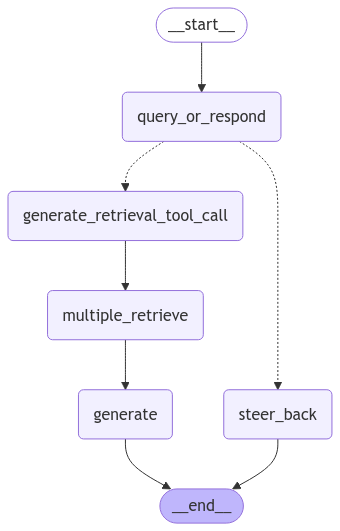

In [29]:
if __name__ == "__main__": 
    graph = get_graph()
    display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
if __name__ == "__main__": 
    response = graph.invoke({"query": "what is technology entrepreneurship and business model?"})
    print('\n'+"*"*80+'\n')
    display(Markdown(response['messages'][-1].content))

Failed to get inputs for (state: __main__.TimReviewState): got an unexpected keyword argument 'config'
Key '$defs' is not supported in schema, ignoring


_format_to_gapic_function_declaration
<class '__main__.DividedQueryList'>
_format_to_gapic_function_declaration
{'type': 'function', 'function': {'name': 'DividedQueryList', 'description': '', 'parameters': {'properties': {'divided_queries': {'description': 'A list of queries for the subtopics.', 'items': {'properties': {'query': {'description': 'Query for the subtopic.', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}, 'type': 'array'}}, 'required': ['divided_queries'], 'type': 'object'}}}


Failed to get inputs for (state: __main__.TimReviewState): got an unexpected keyword argument 'config'
Failed to get inputs for (state: __main__.RetrieveState): got an unexpected keyword argument 'config'
Failed to get inputs for (state: __main__.RetrieveState): got an unexpected keyword argument 'config'


_format_to_gapic_function_declaration
{'type': 'function', 'function': {'name': 'retrieve', 'description': 'Retrieve information from the literatures related to a query.\n\nparam query: The query to search for in cosine similarity.\nparam filter: The filter to apply to the search. The filter is a dictionary with the following keys:\n    - author: The authors of the document\n    - title: The title of the document\n    - year: The year of the document\n    - month: The month of the document. Format: mm/yyyy\n\nreturn: A list of the retrieved documents', 'parameters': {'properties': {'query': {'description': 'The query to retrieve the answer for in cosine similarity.', 'type': 'string'}, 'filter_author': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'description': 'Filter property, the authors of the document'}, 'filter_title': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'description': 'Filter property, the title of the document'}, 'filter_year

Failed to get inputs for (state: __main__.TimReviewState): got an unexpected keyword argument 'config'


*************** Retrieval ***************
Query: technology entrepreneurship
Number of documents retrieved: 5
Documents:
page_content='As a specific type of entrepreneurship, technology entrepreneurship is defined as “an investment in a project that assembles and deploys specialized individuals and heterogeneous assets that are intricately related to advances in scientific and technological knowledge for the purpose of creating and capturing value for a firm” (Bailetti, 2012), and at its heart is the establishment of new technology ventures. Individual technology entrepreneurs have been categorized as researchers, producers, users and opportunists as per their technical orientation and background. However, technology entrepreneurs are often a mix of these attributes. Also, entrepreneurial teams have a combination of these attributes (Jones-Evans, 1995).  Technology entrepreneurs differ in the ways in which they draw on resources and structures to exploit technology opportunities. They 

Based on the provided documents, here's information on technology entrepreneurship and business models:

*Technology Entrepreneurship:*

While the query asks about technology entrepreneurship, only one document mentions it explicitly as a keyword (Khajeheian, 2016). However, the document focuses on audience commodification as a source of innovation in business models, not on defining technology entrepreneurship itself. Therefore, the documents do not provide a direct definition of technology entrepreneurship.

*Business Model:*

There is no universally accepted definition of a "business model" (Morris et al., 2005). The terms business model, strategy, business concept, revenue model, and economic model are often used interchangeably, which leads to confusion in terminology. The business model has been referred to as an architecture, design, pattern, plan, method, assumption, and statement (Morris et al., 2005).

Here are some definitions of a business model from the documents:

*   A statement of how a firm will make money and sustain its profit stream over time (Stewart & Zhao, 2000).
*   The rationale of how an organization creates, delivers, and captures value (Osterwalder & Pigneur, 2010).
*   The design of organizational structures to enact a commercial opportunity (George & Bock, 2011).
*   The design or architecture of the value creation, delivery, and capture mechanisms a business employs (Teece, 2010).
*   The combined elements of ‘who’, ‘what’, ‘when’, ‘why’, ‘where’, ‘how’, and ‘how much’ involved in providing customers and end users with products and services (Mitchell & Coles, 2003).
*   A company’s plans to create and capture value that spans the internal/external boundaries of the firm and its industry (Amit & Zott, 2001; Zott & Amit, 2010).
*   It articulates the value proposition; identifies a market segment and specify the revenue generation mechanism; defines the structure of the value chain required to create and distribute the offering and complementary assets needed to support position in the chain; details the revenue mechanism(s) by which the firm will be paid for the offering; estimates the cost structure and profit potential (given value proposition and value chain structure); describes the position of the firm within the value network linking suppliers and customers (including identifying potential complementors and competitors); and formulates the competitive strategy by which the innovating firm will gain and hold advantage over rivals (Chesbrough, 2010).

Business model activities (e.g., value-chain activities, customer segments, choice of products, services, and revenue mechanisms) involve human, physical and/or capital resources that link value creation with value capture to exploit business opportunities for the parties involved (Chesbrough & Rosenbloom, 2002; Zott & Amit, 2010).

*Reference*

Amit, R., & Zott, C. (2001). Value creation in e-business. _Strategic Management Journal, 22_(6-7), 493-520.

Beckett, R. C., & Dalrymple, J. (2019). Business Model Architecture by Design. _Technology Innovation Management Review, 9_(7), 16-27. https://doi.org/10.22215/timreview/1252

Chesbrough, H. (2010). Business model innovation: Opportunities and barriers. _Long Range Planning, 43_(2-3), 354-363.

Chesbrough, H. W., & Rosenbloom, R. S. (2002). The role of the business model in capturing value from innovation: evidence from Xerox Corporation’s technology spin-off companies. _Industrial and Corporate Change, 11_(3), 529-555.

George, G., & Bock, A. J. (2011). The business model in practice and its implications for entrepreneurship research. _Entrepreneurship Theory and Practice, 35_(1), 83-111.

Khajeheian, D. (2016). Audience Commodification: A Source of Innovation in Business Models. _Technology Innovation Management Review, 6_(8), 40-47. https://doi.org/10.22215/timreview/1010

Mitchell, D. W., & Coles, C. B. (2003). The ultimate competitive advantage: Creating the high-performance company. _Harvard Business Press_.

Moqaddamerad, S. (2020). Visioning Business Model Innovation for Emerging 5G Mobile Communications Networks. _Technology Innovation Management Review, 10_(12), 4-18. https://doi.org/10.22215/timreview/1406

Morris, M., Schindehutte, M., & Allen, J. (2005). The entrepreneur’s business model: toward a unified perspective. _Journal of Business Research, 58_(6), 726-735.

Osterwalder, A., & Pigneur, Y. (2010). _Business model generation: a handbook for visionaries, game changers, and challengers_. John Wiley & Sons.

Stewart, T. A., & Zhao, M. (2000). Strategy in the new economy. _Fortune, 141_(7), 153-156.

Teece, D. J. (2010). Business models, business strategy and innovation. _Long range planning, 43_(2-3), 172-194.

Zott, C., & Amit, R. (2010). Business model design: an activity system perspective. _Long range planning, 43_(2-3), 216-226.


In [31]:
#print(response['messages'][-1].content)

Based on the provided documents, here's information on technology entrepreneurship and business models:

*Technology Entrepreneurship:*

While the query asks about technology entrepreneurship, only one document mentions it explicitly as a keyword (Khajeheian, 2016). However, the document focuses on audience commodification as a source of innovation in business models, not on defining technology entrepreneurship itself. Therefore, the documents do not provide a direct definition of technology entrepreneurship.

*Business Model:*

There is no universally accepted definition of a "business model" (Morris et al., 2005). The terms business model, strategy, business concept, revenue model, and economic model are often used interchangeably, which leads to confusion in terminology. The business model has been referred to as an architecture, design, pattern, plan, method, assumption, and statement (Morris et al., 2005).

Here are some definitions of a business model from the documents:

*   A s

<IPython.core.display.Markdown object>
